# EXPLORATION_11 어제 오른 내 주식, 과연 내일은?

## STEP 1. 시계열 데이터 준비

### <삼성전자 주식 시세 예측>

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

필요한 모듈 import하기! 
Data 칼럼을 DataFrame 이 아니라 Series 형태

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_1 = df['Close']

ts_1.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
## ts_1 type 확인!
print(type(ts_1))

<class 'pandas.core.series.Series'>


## STEP 2. 각종 전처리 수행

만약에 결측치가 있으면 => 제거해줘함  

결측치 처리  
1. 결측치가 있는 데이터를 모두 삭제(drop)  
2. 결측치 양옆의 값들을 이용해서 적절히 보간하여 대입  
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

In [3]:
## 결측치 처리
ts_1 = ts_1.interpolate(method='time')
ts_1[ts_1.isna()]  ## Time Series에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

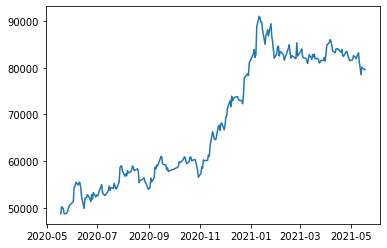

In [4]:
## 그래프로 확인!
plt.plot(ts_1)

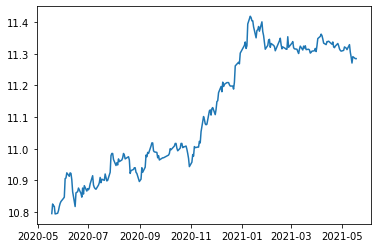

In [5]:
## 로그 변환 시도 
## 로그함수 변환 

ts_log = np.log(ts_1)
plt.plot(ts_log)

## STEP 3. 시계열 안정성 분석

plot_rolling_statistics 는 일정 시간 내 구간 통계치를 시각화해 보는 함수이다.  

현재 타임 스텝에서 부터 -> window 에 주어진 타임 스텝 이전 사이  
1. 구간의 평균(rolling mean, 이동평균) 과  
2. 표준편차(rolling std, 이동표준편차)를  
원본 시계열과 함께 시각화해보면 경향성을 뚜렷하게 확인 가능

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  ## 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    ## 이동표준편차 시계열

     ## 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


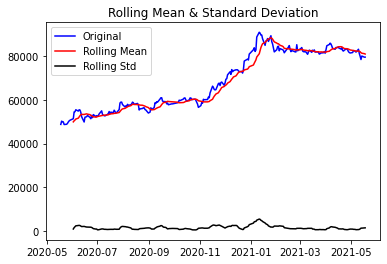

In [7]:
plot_rolling_statistics(ts_1, window=12)

#### statsmodels 패키지와 adfuller 메서드

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다.

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    ## statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    ## adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [9]:
augmented_dickey_fuller_test(ts_1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


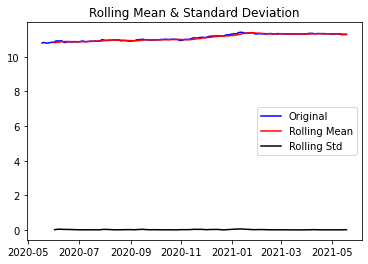

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


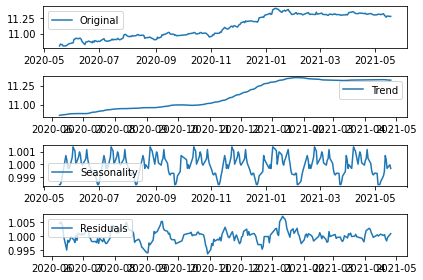

In [10]:
## 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

## 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

## 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4. 학습, 테스트 데이터셋 생성

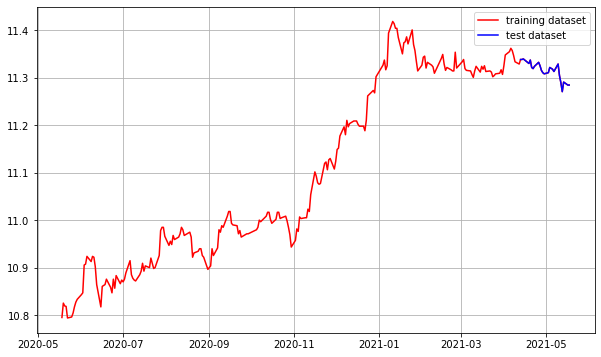

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
## train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기

#### ARIMA 모델의 정의  
ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)이다.  
- AR(자기회귀, Autoregressive)  
- MA(이동평균, Moving Average)  
- I(차분 누적, Integration)

#### ARIMA 모델의 모수 p, q, d  
ARIMA의 모수는 아래의 3가지가 있다.  
- p : 자기회귀 모형(AR)의 시차  
- d : 차분 누적(I) 횟수  
- q : 이동평균 모형(MA)의 시차

#### ACF  
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수  
- 주어진 시계열의 현재 값이 과거(y_{t-1}, y_{t-2}, ...., y_{t-n})값과 어떻게 상관되는지 설명함.  
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

#### PACF  
- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수  
- k 이외의 모든 시차를 갖는 관측치(y_{t-1}, y_{t-2}, ...., y_{t-k+1})의 영향력을 배제한 가운데 특정 두 관측치, y_{t}와 y_{t-k}가 얼마나 관련이 있는지 나타내는 척도.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


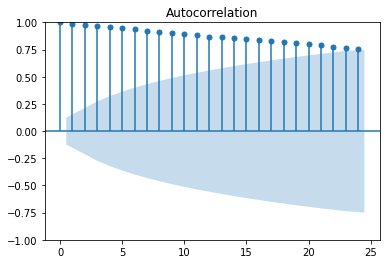

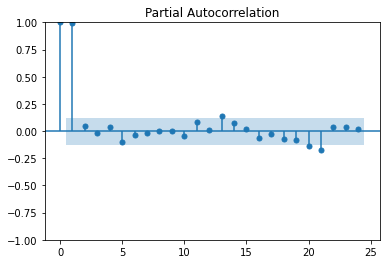

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   ## ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  ## PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### d를 구하려면 d차 차분을 구해 보고 이때 시계열이 안정된 상태인지 확인해봐야한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


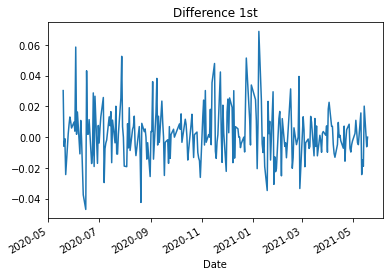

In [14]:
## 1차 차분 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


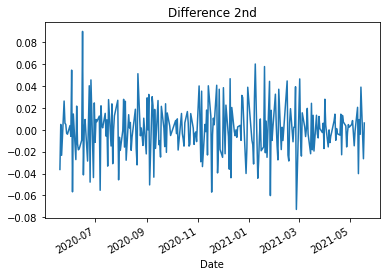

In [15]:
## 2차 차분 구하기

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6. ARIMA 모델 훈련과 테스트

In [16]:
## ARIMA 모델을 훈련하기

from statsmodels.tsa.arima.model import ARIMA
## Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        08:36:21   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


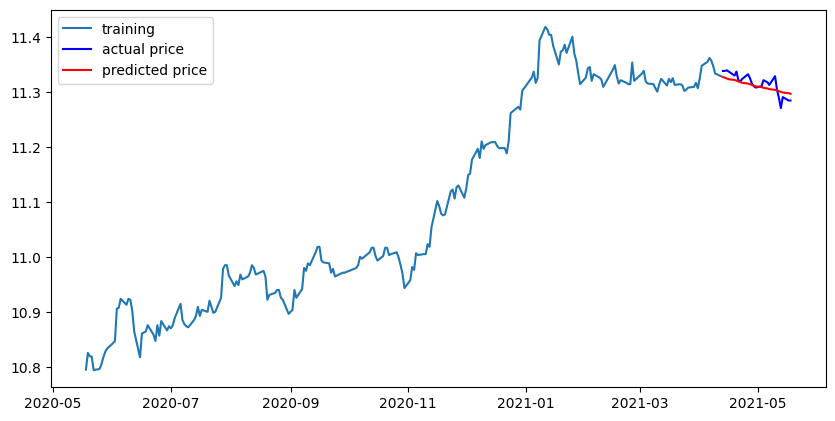

In [17]:
## forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해보기! 
## Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  ## 95% conf
fc = np.array(fc)
## Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   ## 예측결과

## Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 시계열 데이터를 로그 변환해서 사용한 것이 때문에!   
#### 다시 지수 변환을 해야만 정확한 오차를 계산 할 수 있다.

In [18]:
## np.exp() 를 통해서 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### <삼성전자 주식 예측 결과>:  
MAPE : 1.03%  
MAPE 기준으로 1%정도의 오차율을 보인다. 아주 만족스러움

--------------------------------------------------------------------

## STEP 7. 다른 주식 종목 예측해 보기

### 7_1 STEP 1. 시계열 데이터 준비

### <현대 중공업 주식 시세 예측>

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

필요한 모듈 import하기! 
Data 칼럼을 DataFrame 이 아니라 Series 형태

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/267250.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_2 = df['Close']

ts_2.head()

Date
2021-02-17    54000.0
2021-02-18    52700.0
2021-02-19    52400.0
2021-02-22    52100.0
2021-02-23    55900.0
Name: Close, dtype: float64

In [20]:
## ts_2 type 확인!
print(type(ts_2))

<class 'pandas.core.series.Series'>


### 7_1 STEP 2. 각종 전처리 수행

만약에 결측치가 있으면 => 제거해줘함  

결측치 처리  
1. 결측치가 있는 데이터를 모두 삭제(drop)  
2. 결측치 양옆의 값들을 이용해서 적절히 보간하여 대입  
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

In [21]:
## 결측치 처리
ts_2 = ts_2.interpolate(method='time')
ts_2[ts_2.isna()]  ## Time Series에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

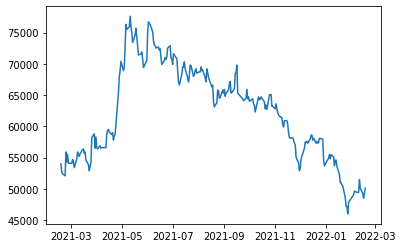

In [22]:
## 그래프로 확인!
plt.plot(ts_2)

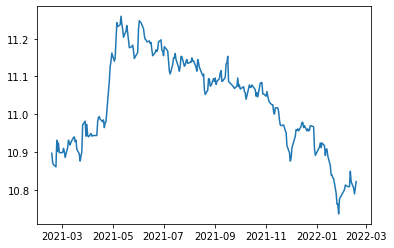

In [23]:
## 로그 변환 시도 
## 로그함수 변환 

ts_log = np.log(ts_2)
plt.plot(ts_log)

### 7_1 STEP 3. 시계열 안정성 분석

plot_rolling_statistics 는 일정 시간 내 구간 통계치를 시각화해 보는 함수이다.  

현재 타임 스텝에서 부터 -> window 에 주어진 타임 스텝 이전 사이  
1. 구간의 평균(rolling mean, 이동평균) 과  
2. 표준편차(rolling std, 이동표준편차)를  
원본 시계열과 함께 시각화해보면 경향성을 뚜렷하게 확인 가능

In [24]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  ## 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    ## 이동표준편차 시계열

     ## 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


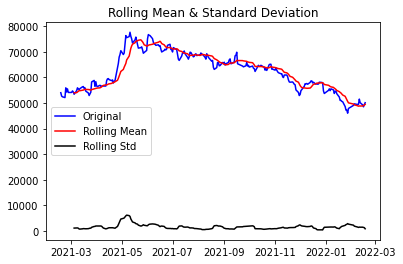

In [25]:
plot_rolling_statistics(ts_2, window=12)

#### statsmodels 패키지와 adfuller 메서드

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다.

In [26]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    ## statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    ## adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [27]:
augmented_dickey_fuller_test(ts_2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.268099
p-value                          0.643638
#Lags Used                       1.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


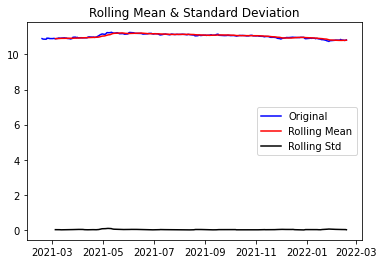

Results of Dickey-Fuller Test:
Test Statistic                  -1.181739
p-value                          0.681401
#Lags Used                       1.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


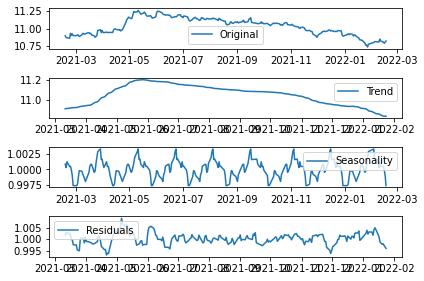

In [28]:
## 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

## 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

## 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.749747e+00
p-value                        6.004841e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 7_1 STEP 4. 학습, 테스트 데이터셋 생성

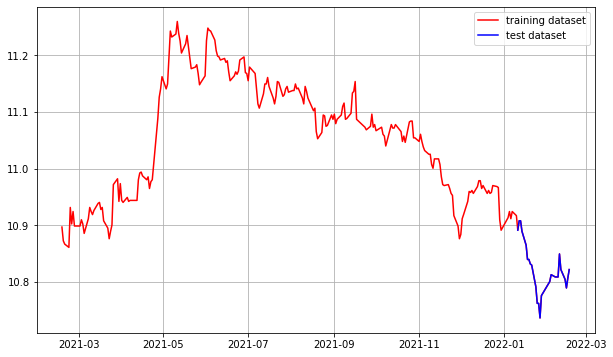

In [30]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
## train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 7_1 STEP 5. 적정 ARIMA 모수 찾기

#### ARIMA 모델의 정의  
ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)이다.  
- AR(자기회귀, Autoregressive)  
- MA(이동평균, Moving Average)  
- I(차분 누적, Integration)

#### ARIMA 모델의 모수 p, q, d  
ARIMA의 모수는 아래의 3가지가 있다.  
- p : 자기회귀 모형(AR)의 시차  
- d : 차분 누적(I) 횟수  
- q : 이동평균 모형(MA)의 시차

#### ACF  
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수  
- 주어진 시계열의 현재 값이 과거(y_{t-1}, y_{t-2}, ...., y_{t-n})값과 어떻게 상관되는지 설명함.  
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

#### PACF  
- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수  
- k 이외의 모든 시차를 갖는 관측치(y_{t-1}, y_{t-2}, ...., y_{t-k+1})의 영향력을 배제한 가운데 특정 두 관측치, y_{t}와 y_{t-k}가 얼마나 관련이 있는지 나타내는 척도.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


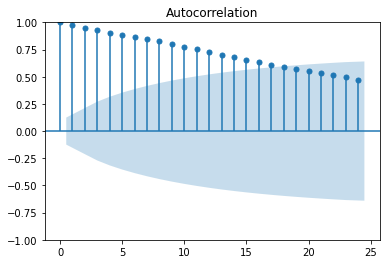

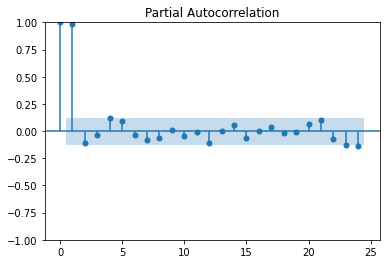

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   ## ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  ## PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### d를 구하려면 d차 차분을 구해 보고 이때 시계열이 안정된 상태인지 확인해봐야한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.464512e+01
p-value                        3.572680e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


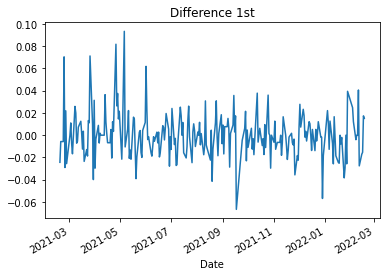

In [32]:
## 1차 차분 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.313379e+00
p-value                        3.736639e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


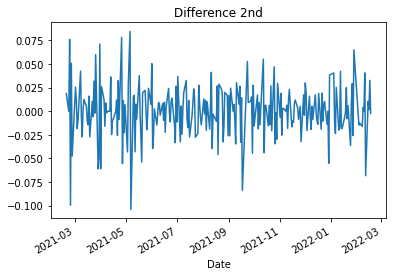

In [33]:
## 2차 차분 구하기

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 7_1 STEP 6. ARIMA 모델 훈련과 테스트

In [34]:
## ARIMA 모델을 훈련하기

from statsmodels.tsa.arima.model import ARIMA
## Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 554.441
Date:                Thu, 17 Feb 2022   AIC                          -1098.882
Time:                        08:36:24   BIC                          -1081.847
Sample:                             0   HQIC                         -1092.005
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0067      0.071    154.307      0.000      10.867      11.147
ar.L1          1.0548      1.001      1.053      0.292      -0.908       3.017
ar.L2         -0.0719      0.983     -0.073      0.9

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


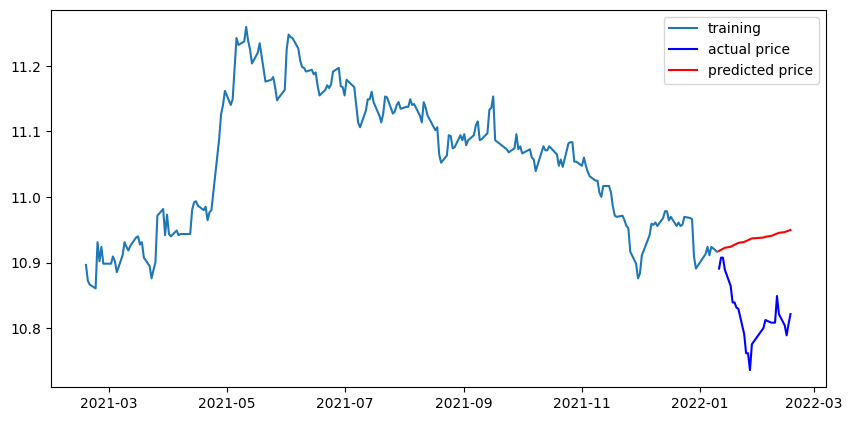

In [35]:
## forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해보기! 
## Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  ## 95% conf
fc = np.array(fc)
## Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   ## 예측결과

## Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 시계열 데이터를 로그 변환해서 사용한 것이 때문에!   
#### 다시 지수 변환을 해야만 정확한 오차를 계산 할 수 있다.

In [36]:
## np.exp() 를 통해서 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  41781711.103396274
MAE:  5931.756083345956
RMSE:  6463.877404731333
MAPE: 12.06%


### <현대 중공업 주식 예측 결과>:  
MAPE : 12.06%  
MAPE 기준으로 12%정도의 오차율을 보인다. 더 적당한 모수를 찾아봐야겠다. 아니면 p값을 개선시켜서 MAPE의 오차율을 좀 더 높여보도록 해야겠다.

--------------------------------------------------------------------

### 7_2 STEP 1. 시계열 데이터 준비

### <NAVER 주식 시세 예측>

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

필요한 모듈 import하기! 
Data 칼럼을 DataFrame 이 아니라 Series 형태

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_3 = df['Close']

ts_3.head()

Date
2021-02-17    392000.0
2021-02-18    388000.0
2021-02-19    398000.0
2021-02-22    386500.0
2021-02-23    390500.0
Name: Close, dtype: float64

In [38]:
## ts_3 type 확인!
print(type(ts_3))

<class 'pandas.core.series.Series'>


### 7_2 STEP 2. 각종 전처리 수행

만약에 결측치가 있으면 => 제거해줘함  

결측치 처리  
1. 결측치가 있는 데이터를 모두 삭제(drop)  
2. 결측치 양옆의 값들을 이용해서 적절히 보간하여 대입  
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

In [41]:
## 결측치 처리
ts_3 = ts_3.interpolate(method='time')
ts_3[ts_3.isna()]  ## Time Series에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

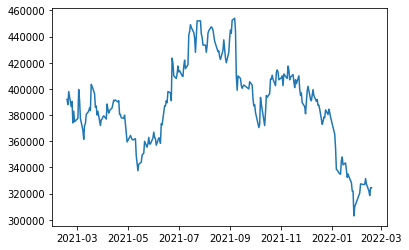

In [42]:
## 그래프로 확인!
plt.plot(ts_3)

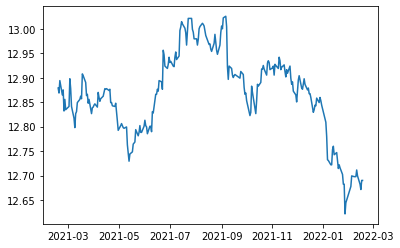

In [43]:
## 로그 변환 시도 
## 로그함수 변환 

ts_log = np.log(ts_3)
plt.plot(ts_log)

plot_rolling_statistics 는 일정 시간 내 구간 통계치를 시각화해 보는 함수이다.  

현재 타임 스텝에서 부터 -> window 에 주어진 타임 스텝 이전 사이  
1. 구간의 평균(rolling mean, 이동평균) 과  
2. 표준편차(rolling std, 이동표준편차)를  
원본 시계열과 함께 시각화해보면 경향성을 뚜렷하게 확인 가능

In [44]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  ## 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    ## 이동표준편차 시계열

     ## 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


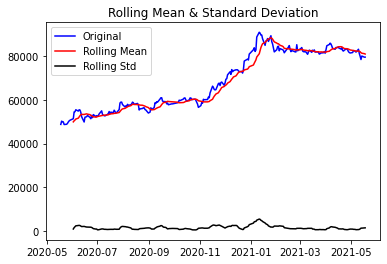

In [45]:
plot_rolling_statistics(ts_1, window=12)

#### statsmodels 패키지와 adfuller 메서드

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다.

In [46]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    ## statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    ## adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [47]:
augmented_dickey_fuller_test(ts_3)

Results of Dickey-Fuller Test:
Test Statistic                  -1.055691
p-value                          0.732415
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


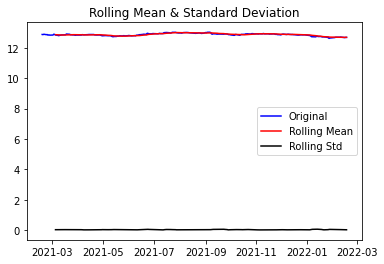

Results of Dickey-Fuller Test:
Test Statistic                  -0.964423
p-value                          0.766018
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


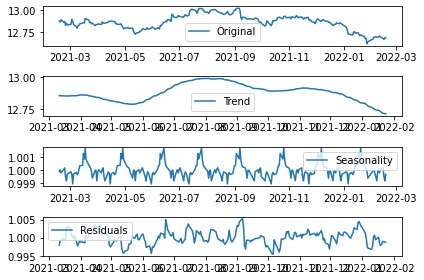

In [48]:
## 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

## 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

## 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.139481e+00
p-value                        8.035904e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


### 7_2 STEP 4. 학습, 테스트 데이터셋 생성

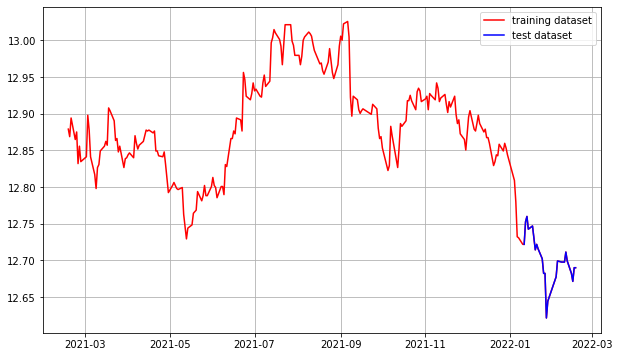

In [50]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
## train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 7_2 STEP 5. 적정 ARIMA 모수 찾기

#### ARIMA 모델의 정의  
ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)이다.  
- AR(자기회귀, Autoregressive)  
- MA(이동평균, Moving Average)  
- I(차분 누적, Integration)

#### ARIMA 모델의 모수 p, q, d  
ARIMA의 모수는 아래의 3가지가 있다.  
- p : 자기회귀 모형(AR)의 시차  
- d : 차분 누적(I) 횟수  
- q : 이동평균 모형(MA)의 시차

#### ACF  
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수  
- 주어진 시계열의 현재 값이 과거(y_{t-1}, y_{t-2}, ...., y_{t-n})값과 어떻게 상관되는지 설명함.  
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

#### PACF  
- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수  
- k 이외의 모든 시차를 갖는 관측치(y_{t-1}, y_{t-2}, ...., y_{t-k+1})의 영향력을 배제한 가운데 특정 두 관측치, y_{t}와 y_{t-k}가 얼마나 관련이 있는지 나타내는 척도.

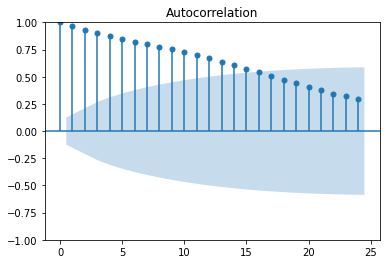

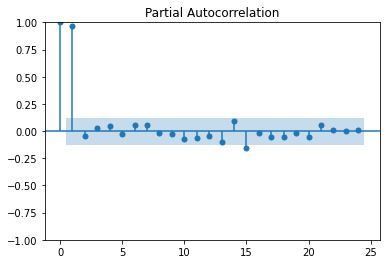

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   ## ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  ## PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### d를 구하려면 d차 차분을 구해 보고 이때 시계열이 안정된 상태인지 확인해봐야한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.202367e+01
p-value                        2.983095e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


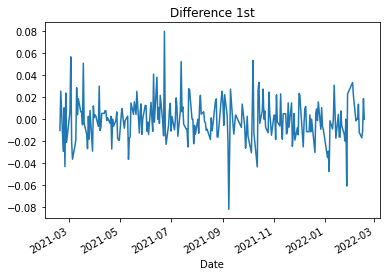

In [52]:
## 1차 차분 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.853831e+00
p-value                        5.510049e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


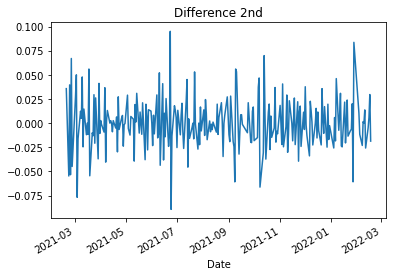

In [53]:
## 2차 차분 구하기

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 7_2 STEP 6. ARIMA 모델 훈련과 테스트

In [54]:
## ARIMA 모델을 훈련하기

from statsmodels.tsa.arima.model import ARIMA
## Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 568.466
Date:                Thu, 17 Feb 2022   AIC                          -1126.933
Time:                        08:49:33   BIC                          -1109.897
Sample:                             0   HQIC                         -1120.056
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8697      0.043    301.777      0.000      12.786      12.953
ar.L1          0.6095      0.793      0.769      0.442      -0.944       2.163
ar.L2          0.3427      0.769      0.446      0.6

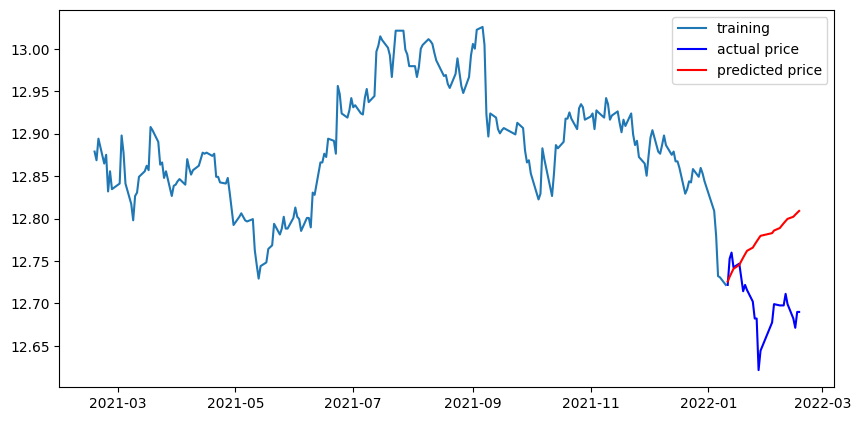

In [55]:
## forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해보기! 
## Forecast : 결과가 fc에 담깁니다. 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  ## 95% conf
fc = np.array(fc)
## Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   ## 예측결과

## Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 시계열 데이터를 로그 변환해서 사용한 것이 때문에!   
#### 다시 지수 변환을 해야만 정확한 오차를 계산 할 수 있다.

In [56]:
## np.exp() 를 통해서 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  879499379.415645
MAE:  25479.143942747927
RMSE:  29656.35478975198
MAPE: 7.89%


### <NAVER 주식 예측 결과>:  
MAPE : 7.89%  
MAPE 기준으로 8%정도의 오차율을 보인다. 오차율이 엄청 높지는 않은 데 ! 또 엄청 낮지도 않아서 위에 현대중공업과 마찬가지로 p값을 수정해서 오차율을 낮춰봐야겠다.

# 회고!

## < 어려웠던 점>  
그냥 검정통계랑, 시계열분석, p-value, ARIMA 모델 등 개념을 알고 있었는데 코드로 구현시켜서 확인하는게 어려웠던 것 같다. 통계를 배울 때 개념으로 문제를 풀어봤지 직접 코드로 해석하고 결과를 나타낸 적이 처음이라 어려웠던 것 같다. 하지만 개념을 알 고 있으니까 노드 느낌을 확실하게 이해한 것 같아서 또 좋았다.

## < 알아낸 점> & < 아직까지 모호한 점>  
 ACF 와 PACF 에 대해서는 처음 알게 된 개념이다.   

#### ACF  
- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수  
- 주어진 시계열의 현재 값이 과거(y_{t-1}, y_{t-2}, ...., y_{t-n})값과 어떻게 상관되는지 설명함.  
- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄  

#### PACF  
- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수  
- k 이외의 모든 시차를 갖는 관측치(y_{t-1}, y_{t-2}, ...., y_{t-k+1})의 영향력을 배제한 가운데 특정 두 관측치, y_{t}와 y_{t-k}가 얼마나 관련이 있는지 나타내는 척도.   

그리고 MAPE로 오차율을 확인하는 것도 처음 알았던 것 같다.   
MAPE는 평균 절대비오차이고 평균 절대 백분율 편차라고도 한다.  
평균 절대 백분율 오류는 통계에서 예측 방법의 예측 정확도를 측정한 것이다. 일반적으로 다음 공식으로 정의된 비율로 정확도를 나타낸다.

## <시도한 것들>  
<결과>: 

##### <삼성전자 주식 예측 결과>:  
MAPE : 1.03%  
MAPE 기준으로 1%정도의 오차율을 보인다. 아주 만족스러움  

##### <현대 중공업 주식 예측 결과>:  
MAPE : 12.06%  
MAPE 기준으로 12%정도의 오차율을 보인다. 더 적당한 모수를 찾아봐야겠다. 아니면 p값을 개선시켜서 MAPE의 오차율을 좀 더 높여보도록 해야겠다.  

##### <NAVER 주식 예측 결과>:  
MAPE : 7.89%  
MAPE 기준으로 8%정도의 오차율을 보인다. 오차율이 엄청 높지는 않은 데 ! 또 엄청 낮지도 않아서 위에 현대중공업과 마찬가지로 p값을 수정해서 오차율을 낮춰봐야겠다.  



## < 자기 다짐>  
뭔가 통계공부를 하면서 배웠었던 개념을 가지고 하니까 더 이해가 잘 되고 재밌었던 것 같다. 한 마디로 공부를 해서 개념을 알고 노드를 진행하면 더 이해가 잘 되고 재밌으니까! 공부를 좀 더 해야겠다고 느꼈다.. 뭔가 노드를 떠나서 개념적이나 기본적인 파이썬 코드를 공부를 좀 더 해야겠다!!! 노드 개념도 좋은데 아직까지 어려운 것도 있으니까...노드도 물론 공부를 하겠지만 그냥 내가 공부가 필요한 부분 공부를 우선으로 해야겠다.!